In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from ucimlrepo import fetch_ucirepo


In [36]:
# new preprocessing

df = pd.read_csv("diabetic_data.csv")
df.drop_duplicates(subset="patient_nbr", keep="first", inplace=True)
X = df.drop(['encounter_id','patient_nbr','readmitted'], axis = 'columns')
y = df["readmitted"]
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = math.ceil((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i + 1})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# plotPerColumnDistribution(X, 15, 5)
columns_to_drop = ['weight', 'payer_code', 'medical_specialty']

# drop features: weight, payer_code, medical_specialty, max_glu_serum, A1Cresult
X = X.drop(columns=columns_to_drop)
X.drop(X[X['gender'] == 'Unknown/Invalid'].index, inplace=True)

# labels = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury',
#           'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other']
def map_icd_to_category(icd_code):
    try:
        icd_code = float(icd_code)
    except ValueError:
        return "Other"
    if 390 <= icd_code <= 459 or icd_code == 785:
        return 'Circulatory'
    elif 460 <= icd_code <= 519 or icd_code == 786:
        return 'Respiratory'
    elif 520 <= icd_code <= 579 or icd_code == 787:
        return 'Digestive'
    elif str(icd_code).startswith('250'):
        return 'Diabetes'
    elif 800 <= icd_code <= 999:
        return 'Injury'
    # Musculoskeletal
    elif 710 <= icd_code <= 739:
        return 'Musculoskeletal'
    # Genitourinary
    elif 580 <= icd_code <= 629 or icd_code == 788:
        return 'Genitourinary'
    # Neoplasms
    elif 140 <= icd_code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

X['diag_1'] = X['diag_1'].apply(map_icd_to_category)
X['diag_2'] = X['diag_2'].apply(map_icd_to_category)
X['diag_3'] = X['diag_3'].apply(map_icd_to_category)

categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(X[categorical_columns])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_encoded = pd.concat([X_encoded, X.drop(columns=categorical_columns)], axis=1)

column_variances = X_encoded.var()
nzv = set()
# set of near zero variance features
for column, variance in column_variances.items():
    if variance < .001:
        nzv.add(column.split('_')[0])

columns_to_drop = []
for column in X_encoded.columns:
    parts = column.split('_')
    if parts[0] in nzv:
        columns_to_drop.append(column)

X_encoded = X_encoded.drop(columns=columns_to_drop)
missing_values = X_encoded.isnull().any(axis=1)
y = y.reset_index(drop=True)
X_encoded = X_encoded[~missing_values]
y = y[~missing_values]

y = y.map({'<30': 1, '>30': 0, 'NO': 0})

# pd.set_option('display.max_columns', None)
# print(X_encoded.head(1000))
print("After preprocessing...")
print("Number of features: ", X_encoded.shape[1])
print("Number of patients: ", len(y))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

/Users/typhic/Developer/diabetes-classifiers/env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


After preprocessing...
Number of features:  96
Number of patients:  52671


In [3]:
# old preprocessing

diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

columns_to_drop = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']

# drop features: weight, payer_code, medical_specialty, max_glu_serum, A1Cresult
X = X.drop(columns=columns_to_drop)
X.drop(X[X['gender'] == 'Unknown/Invalid'].index, inplace=True)
# results in 105 column features after transform

# labels = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury',
#           'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other']
def map_icd_to_category(icd_code):
    try:
        icd_code = float(icd_code)
    except ValueError:
        return "Other"
    if 390 <= icd_code <= 459 or icd_code == 785:
        return 'Circulatory'
    elif 460 <= icd_code <= 519 or icd_code == 786:
        return 'Respiratory'
    elif 520 <= icd_code <= 579 or icd_code == 787:
        return 'Digestive'
    elif str(icd_code).startswith('250'):
        return 'Diabetes'
    elif 800 <= icd_code <= 999:
        return 'Injury'
    # Musculoskeletal
    elif 710 <= icd_code <= 739:
        return 'Musculoskeletal'
    # Genitourinary
    elif 580 <= icd_code <= 629 or icd_code == 788:
        return 'Genitourinary'
    # Neoplasms
    elif 140 <= icd_code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

X['diag_1'] = X['diag_1'].apply(map_icd_to_category)
X['diag_2'] = X['diag_2'].apply(map_icd_to_category)
X['diag_3'] = X['diag_3'].apply(map_icd_to_category)

categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(X[categorical_columns])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_encoded = pd.concat([X_encoded, X.drop(columns=categorical_columns)], axis=1)

column_variances = X_encoded.var()
nzv = set()
# set of near zero variance features
for column, variance in column_variances.items():
    if variance < .001:
        nzv.add(column.split('_')[0])

columns_to_drop = []
for column in X_encoded.columns:
    parts = column.split('_')
    if parts[0] in nzv:
        columns_to_drop.append(column)

X_encoded = X_encoded.drop(columns=columns_to_drop)

missing_values = X_encoded.isnull().any(axis=1)
X_encoded = X_encoded[~missing_values]
y = y[~missing_values]

y['readmitted'] = y['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})

# pd.set_option('display.max_columns', None)
# print(X_encoded.head(1000))


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

/Users/typhic/Developer/diabetes-classifiers/env/lib/python3.10/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
/Users/typhic/Developer/diabetes-classifiers/env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/s5/k6trn90j33d0tmx0hr2tj85r0000gn/T/ipykernel_44360/1270677017.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['readmitted'] = y['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})


In [54]:
# logistic_classifier
import timeit

train_accuracies = []
test_accuracies = []
conf_matrices = []
models = dict()

cs = [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for c in cs:
    if c == 0:
        classifier = LogisticRegression(penalty=None, max_iter=1000, fit_intercept=True)
    else:
        classifier = LogisticRegression(penalty='l2', C=c, max_iter=2000, solver='sag', fit_intercept=True)
    classifier.fit(X_train, y_train.values.ravel())
    train_accuracies.append(classifier.score(X_train, y_train))
    test_accuracies.append(classifier.score(X_val, y_val))
    conf_matrices.append(confusion_matrix(y_val, classifier.predict(X_val)))
    print(f"Concluded training with C={c}")
    models[c] = classifier

Concluded training with C=0
Concluded training with C=0.0001
Concluded training with C=0.001
Concluded training with C=0.01
Concluded training with C=0.1
Concluded training with C=1.0
Concluded training with C=10.0
Concluded training with C=100.0


In [73]:
# Prediction speed
prediction_speeds = dict()
print(len(models))
for c in cs:
    model = models[c]
    # get prediction speed for entire validation set 1000 times, average
    pred = []
    for i in range(1000):    
        start = timeit.default_timer()
        models[10].predict(X_val)
        end = timeit.default_timer()
        pred.append((end - start)/len(X_val))
    prediction_speeds[c] = (sum(pred)/len(pred))
    print(f"Avg Prediction speed for C={c}: {(sum(pred)/len(pred))} seconds")
print(len(prediction_speeds))

8
Avg Prediction speed for C=0: 4.992080462502121e-07 seconds
Avg Prediction speed for C=0.0001: 4.2598198315718205e-07 seconds
Avg Prediction speed for C=0.001: 3.9408398229942565e-07 seconds
Avg Prediction speed for C=0.01: 4.648313327711348e-07 seconds
Avg Prediction speed for C=0.1: 3.7545153258373634e-07 seconds
Avg Prediction speed for C=1.0: 4.113483702391514e-07 seconds
Avg Prediction speed for C=10.0: 3.7497079903868936e-07 seconds
Avg Prediction speed for C=100.0: 4.805108095631953e-07 seconds
8


In [75]:
# collect accuracy, precision, recall, and roc_auc scores
accuracies = dict()
precisions = dict()
recalls = dict()
roc_aucs = dict()
for c in cs:
    y_pred = models[c].predict(X_val)
    accuracies[c]=accuracy_score(y_val, y_pred)
    precisions[c]=precision_score(y_val, y_pred)
    recalls[c]=recall_score(y_val, y_pred)
    roc_aucs[c]=roc_auc_score(y_val, y_pred)


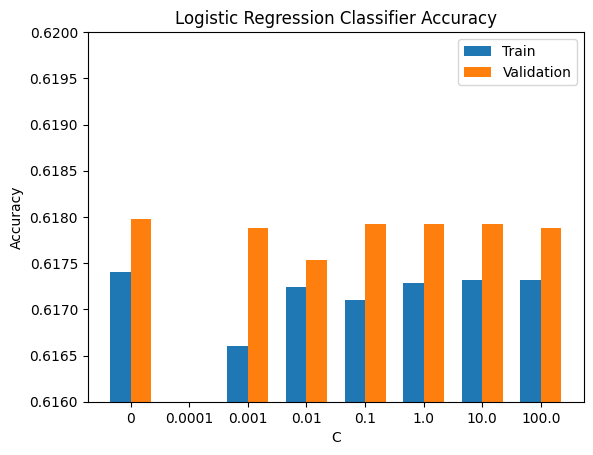

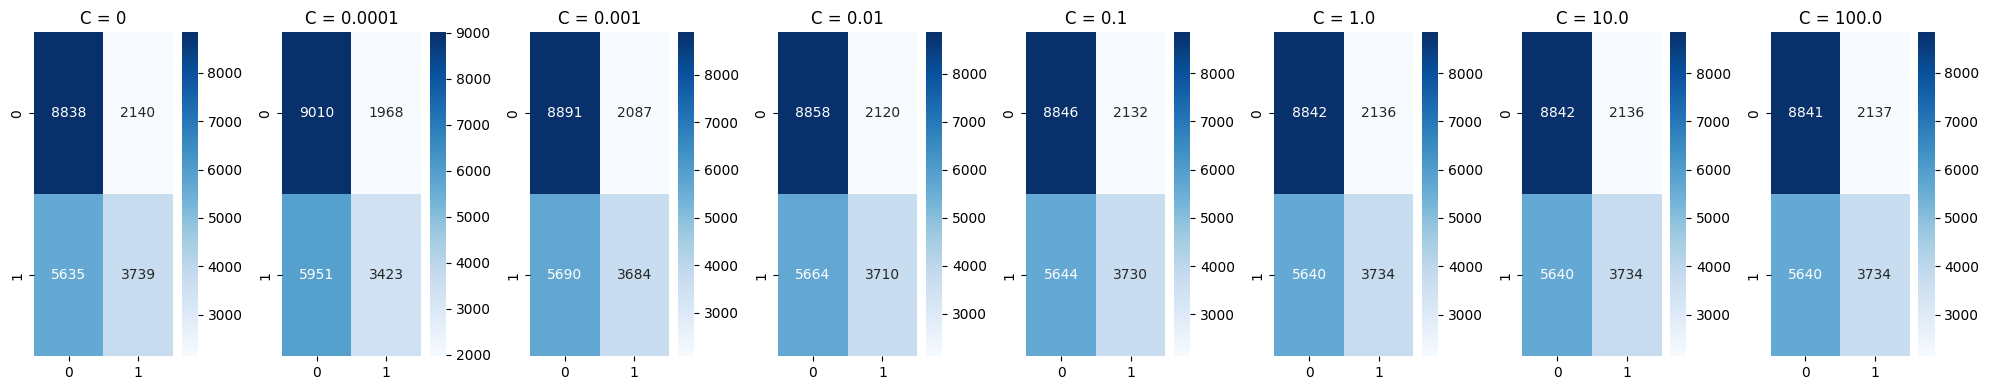

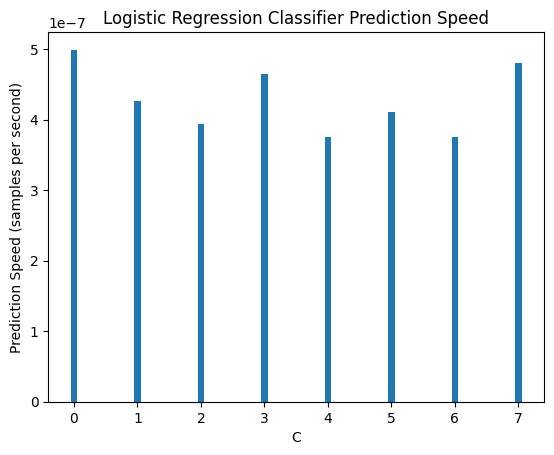

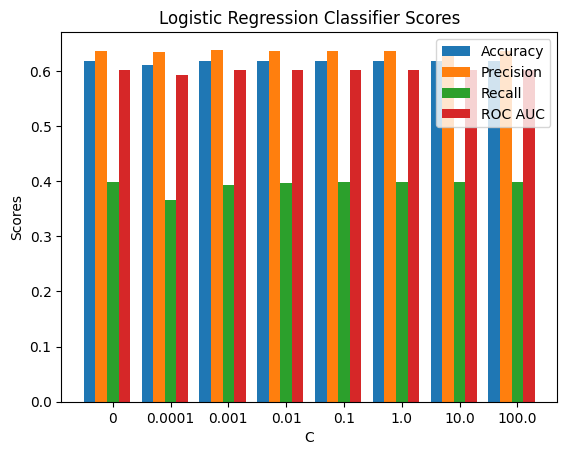

Model statistics
Accuracy:  0.6179245283018868
Precision:  0.6361158432708688
Recall:  0.398335822487732
ROC AUC:  0.6018824311928549
Prediction speed:  3.7497079903868936e-07
{0: 4.992080462502121e-07, 0.0001: 4.2598198315718205e-07, 0.001: 3.9408398229942565e-07, 0.01: 4.648313327711348e-07, 0.1: 3.7545153258373634e-07, 1.0: 4.113483702391514e-07, 10.0: 3.7497079903868936e-07, 100.0: 4.805108095631953e-07}


In [76]:
# logistic regression classifier plotting

# plot accuracies from dictionary
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(cs))
train_bars = ax.bar(index, train_accuracies, bar_width, label='Train')
test_bars = ax.bar(index + bar_width, test_accuracies, bar_width, label='Validation')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression Classifier Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cs)
ax.set_ylim(0.616, 0.62)
ax.legend()
plt.show()

# plot confusion matrix
fig, axes = plt.subplots(1, 8, figsize=(20, 4))
for i, conf_matrix in enumerate(conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'C = {cs[i]}')
    
plt.tight_layout()
plt.show()

# plot prediction speed
fig, ax = plt.subplots()
bar_width = 0.1
index = np.arange(len(cs))
# use new dictionary structure
speed_bars = ax.bar(index, prediction_speeds.values(), bar_width)

ax.set_xlabel('C')
ax.set_ylabel('Prediction Speed (samples per second)')
ax.set_title('Logistic Regression Classifier Prediction Speed')
plt.show()

# plot accuracy, precision, recall, and roc_auc scores
fig, ax = plt.subplots()
bar_width = 0.2
index = np.arange(len(cs))
accuracy_bars = ax.bar(index, accuracies.values(), bar_width, label='Accuracy')
precision_bars = ax.bar(index + bar_width, precisions.values(), bar_width, label='Precision')
recall_bars = ax.bar(index + 2 * bar_width, recalls.values(), bar_width, label='Recall')
roc_auc_bars = ax.bar(index + 3 * bar_width, roc_aucs.values(), bar_width, label='ROC AUC')
ax.set_xlabel('C')
ax.set_ylabel('Scores')
ax.set_title('Logistic Regression Classifier Scores')
ax.set_xticks(index + 2 * bar_width)
ax.set_xticklabels(cs)
ax.legend()
plt.show()


# # plot accuracies
# fig, ax = plt.subplots()
# bar_width = 0.35
# index = np.arange(len(cs))
# train_bars = ax.bar(index, train_accuracies, bar_width, label='Train')
# test_bars = ax.bar(index + bar_width, test_accuracies, bar_width, label='Validation')
# ax.set_xlabel('C')
# ax.set_ylabel('Accuracy')
# ax.set_title('Logistic Regression Classifier Accuracy')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(cs)
# ax.set_ylim(0.616, 0.62)
# ax.legend()

# # plot confusion matrix
# fig, axes = plt.subplots(1, 8, figsize=(20, 4))
# for i, conf_matrix in enumerate(conf_matrices):
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
#     axes[i].set_title(f'C = {cs[i]}')

# plt.tight_layout()
    
# # plot prediction speed
# fig, ax = plt.subplots()
# print(prediction_speeds)
# bar_width = 0.1
# index = np.arange(len(cs))
# speed_bars = ax.bar(index, prediction_speeds, bar_width)
# # set x range to log scale
# ax.set_xscale('log')
# ax.set_xlabel('C')
# ax.set_ylabel('Prediction Speed (samples per second)')
# ax.set_title('Logistic Regression Classifier Prediction Speed')
# plt.show()

# # plot accuracy, precision, recall, and roc_auc scores
# fig, ax = plt.subplots()
# bar_width = 0.2
# index = np.arange(len(cs))
# accuracy_bars = ax.bar(index, accuracies, bar_width, label='Accuracy')
# precision_bars = ax.bar(index + bar_width, precisions, bar_width, label='Precision')
# recall_bars = ax.bar(index + 2 * bar_width, recalls, bar_width, label='Recall')
# roc_auc_bars = ax.bar(index + 3 * bar_width, roc_aucs, bar_width, label='ROC AUC')
# ax.set_xlabel('C')
# ax.set_ylabel('Scores')
# ax.set_title('Logistic Regression Classifier Scores')
# ax.set_xticks(index + 2 * bar_width)
# ax.set_xticklabels(cs)
# ax.legend()
# plt.show()

# # print the statistics of the last model
# print("Model statistics")
# print("Accuracy: ", accuracies[-1])
# print("Precision: ", precisions[-1])
# print("Recall: ", recalls[-1])
# print("ROC AUC: ", roc_aucs[-1])
# print("Prediction speed: ", prediction_speeds[-1])

# print the statistics of c=10
print("Model statistics")
print("Accuracy: ", accuracies[10])
print("Precision: ", precisions[10])
print("Recall: ", recalls[10])
print("ROC AUC: ", roc_aucs[10])
print("Prediction speed: ", prediction_speeds[10])
print(prediction_speeds)



In [6]:
import timeit
prediction_speeds = dict()

In [7]:
# neural network

mlp_model = MLPClassifier(max_iter = 300, hidden_layer_sizes = (64, 64, 64), activation = 'logistic', learning_rate_init=.05, learning_rate= 'adaptive', solver = 'sgd')
mlp_model.fit(X_train, y_train.values.ravel())

pred = []
for i in range(1000):    
    start = timeit.default_timer()
    mlp_model.predict(X_val)
    end = timeit.default_timer()
    pred.append((end - start)/len(X_val))
prediction_speeds['nn'] = (sum(pred)/len(pred))


In [8]:
# logistic classifier
classifier = LogisticRegression(penalty='l2', C=10, max_iter=2000, solver='sag', fit_intercept=True)
classifier.fit(X_train, y_train.values.ravel())

pred = []
for i in range(1000):    
    start = timeit.default_timer()
    classifier.predict(X_val)
    end = timeit.default_timer()
    pred.append((end - start)/len(X_val))
prediction_speeds['lc'] = (sum(pred)/len(pred))


In [12]:
# knn
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

In [25]:
# accuracy metrics for knn
y_pred = knn_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print("KNN")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("ROC AUC: ", roc_auc)



KNN
Accuracy:  0.57124606918239
Precision:  0.5383613544873312
Recall:  0.4850650736078515
ROC AUC:  0.564950099201448


In [20]:
pred = []
for i in range(100):    
    start = timeit.default_timer()
    knn_classifier.predict(X_val)
    end = timeit.default_timer()
    pred.append((end - start)/len(X_val))
prediction_speeds['knn'] = (sum(pred)/len(pred))

In [21]:
# random forest
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=4, min_samples_leaf=1, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

pred = []
for i in range(1000):    
    start = timeit.default_timer()
    rf_classifier.predict(X_val)
    end = timeit.default_timer()
    pred.append((end - start)/len(X_val))
prediction_speeds['rf'] = (sum(pred)/len(pred))

/Users/typhic/Developer/diabetes-classifiers/env/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [26]:
test_acc = accuracy_score(y_test, y_pred)
test_pre = precision_score(y_test, y_pred)
test_rec = recall_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)
# y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# test_auc = roc_auc_score(y_test, y_pred_prob)
print("Random Forest Classifier")
print("Accuracy: ", test_acc)
print("Precision: ", test_pre)
print("Recall: ", test_rec)
print("ROC AUC: ", test_auc)

Random Forest Classifier
Accuracy:  0.5070263364779874
Precision:  0.45998105612124085
Recall:  0.41519717858287913
ROC AUC:  0.5001861290822536


In [22]:
print(prediction_speeds)

{'nn': 2.344951835331825e-06, 'lc': 2.1767730320034234e-07, 'knn': 6.235421989933468e-05, 'rf': 9.330611281302759e-06}
